## Enough Good Data

In [12]:
using Plots
using Random
using Distributions
using LinearAlgebra
include("pogm_restart_original.jl") # issues adding MIRT so will use julia file instead
rng = Random.seed!(0)
N = 100
D = 100
d = 10
σ1 = 2
σ2 = 35
goodpts = 10
X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    X[:,k] = U1*U1'*rand(Uniform(-100,100),D)
end
for j=1:N
        if (j<= goodpts)
            Y[:,j] = X[:,j] + rand(Normal(0,σ1),D)
            Π[j] = σ1^2
        else
            Y[:,j] = X[:,j] + rand(Normal(0,σ2),D)
            Π[j] = σ2^2
        end
end

In [65]:
function RPCA_ADMM(Y, λr, rank, μ, ρ)
    X = zeros(size(Y))
    E = zeros(size(Y))
    Λ = zeros(size(Y))
    normY = norm(Y,2)
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function l21_prox(z, λ)
        return (1-(λ/(max(λ,norm(z,2))))) .* z
    end
    function svst(x,t)
        U,S,Vt = svd(x)
        return U*diagm(soft.(S, t))*Vt'
    end
    while norm(Y-X-E,2)/normY > 1e-6
        X = svst(Y-E+(1/μ)*Λ, λr/μ)
        #E = μ*inv((μ+1)*I)*(Y-X+(1/μ)*Λ)
        E = transpose(l21_prox(transpose(Y-X+(1/μ)*Λ), 1/μ))
        Λ = Λ + μ*(Y-X-E)
        μ = ρ*μ
    end
    U = svd(X).U[:,1:rank]   
    return U
end
function HPCA_POGM(Y, λr, w, N, rank, ϵ)
    #objective = (X,Z,λr,Π) -> λr*nucnorm(X) + (1/2)*norm(Z*(Diagonal(Π.^-0.5)), 2)
    Π = w.^-1
    Lf = maximum(Π)
    Π = Diagonal(Π)
    x0 = zeros(size(Y))
    grad = K -> -1*(Y-K)*Π
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, N)
    W, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=ϵ) # objective(x,Y-x,λr,w)
    U = svd(W).U[:,1:rank]
    return U
end
function HPCA_ADMM(Y, λr, w, N, μ, ρ, d)
    X = zeros(size(Y))
    Z = zeros(size(Y))
    #U_svd = svd(Y).U[:,1:N]
    #X = deepcopy(U_svd*U_svd'*Y)
    #X0 = zeros(size(Y)) .+ 1
    Z = deepcopy(Y-X)
    Π = Diagonal(w.^-1)
    #Λ = zeros(size(Y))
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    #while norm(Y-X-Z,2)/normY > 1e-6
    #while norm(X-X0)/norm(X0) > 1e-6
    #for i = 1:3000
    while ((norm(Y-X-Z,2)/normY > 1e-6) || (count <100))
        #X0 = X
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Λ = Λ + μ*(Y-X-Z)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:d]   
    return U
end
function weightedPCA(Y , w, k)
    L = unique(w)
    Σ = zeros(size(Y)[1], size(Y)[1])
    for i=1:length(L)
        ind = findall(x -> x == L[i], w)
        Σ = Σ + L[i]*(Y[:,ind]*Y[:,ind]')
    end
    U = reverse(eigvecs(Σ), dims=2)
    Ȳ = reshape(shuffle(Y[:]), size(Y))
    U_Y = svd(Y).S
    U_Ȳ = svd(Ȳ).S
    #k = floor(Int, norm(U_Y .> U_Ȳ, 0))
    return U[:,1:k] #, k
end
U_WPCA = weightedPCA(Y,Π.^-1,d)
error_wpca_10 = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)
U_WPCA = weightedPCA(Y,Π.^-1,9)
error_wpca_8 = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)
U_WPCA = weightedPCA(Y,Π.^-1,11)
error_wpca_12 = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)
using HePPCAT
heppCAT_matrix = []
push!(heppCAT_matrix, Y[:,1:goodpts])
push!(heppCAT_matrix, Y[:,(goodpts+1):end])
homoPCA = heppcat(heppCAT_matrix,d,0)   # init is homoscedastic PPCA
knownvar = deepcopy(homoPCA)
knownvar.v[1] = σ1^2
knownvar.v[2] = σ2^2
heppCAT_known = heppcat(heppCAT_matrix,d,1000;init=knownvar,vknown=true);
error_heppcat = norm(heppCAT_known.U*heppCAT_known.U' - U1*U1', 2)/norm(U1*U1', 2)
error_homoppca = norm(homoPCA.U*homoPCA.U' - U1*U1', 2)/norm(U1*U1', 2)

0.911788038925258

In [180]:
# Ȳ = reshape(shuffle(Y[:]), size(Y))
# M_Y = svd(Y).S
# M_Ȳ = svd(Ȳ).S
# predictedRank = floor(Int, norm(M_Y .> M_Ȳ, 0))

10

In [66]:
maximum(Π.^-1)

0.25

## HPCA-NNM

In [181]:
λr = vcat(0:0.1:1,1:0.5:10)
error_rpca = zeros(size(λr))
λr[1] = 0.001
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_RPCA = HPCA_POGM(Y, λr[i],Π, 0,d,1e-6)  #RPCA_ADMM(Y, λr[i], d, 0.01, 1.005)
    error_rpca[i] = norm(U_RPCA*U_RPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


## HPCA-10

In [375]:
include("pogm_restart.jl")
λr = vcat(0:0.1:1,1:0.5:10)
λr[1] = 0.001
error_hpca = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_POGM(Y, λr[i], Π, 10, d, 1e-6) #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [333]:
colors = theme_palette(:auto).colors

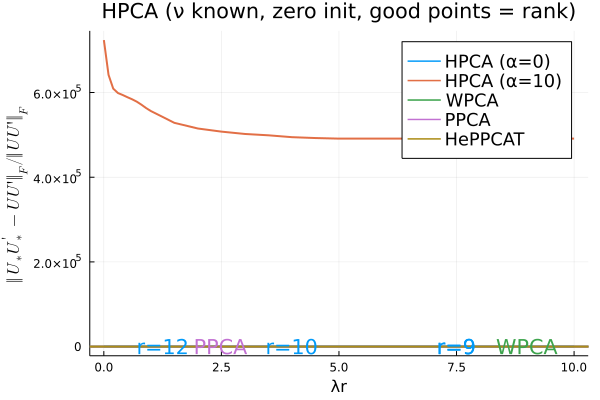

In [376]:
color_index = theme_palette(:auto).colors
using LaTeXStrings
plot(λr, error_rpca, label="HPCA (α=0)", title="HPCA (ν known, zero init, good points = rank)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2,legendfontsize=12.0)
plot!(λr, error_hpca, label="HPCA (α=10)",linewidth=2)
#plot!(λr, error_hpca_2, label="HPCA (r=9)",linewidth=2)
hline!([error_wpca], label="WPCA", linewidth=2)
hline!([error_homoppca], label="PPCA", linewidth=2)
hline!([error_heppcat], label="HePPCAT",linewidth=2)
annotate!(1.25, 0.425, "r=12", color_index[1])
annotate!(4, 0.5, "r=10", color_index[1])
annotate!(7.5, 0.575, "r=9", color_index[1])
annotate!(7.5, 0.575, "r=9", color_index[1])
annotate!(2.5, 0.87, "PPCA", color_index[4])
annotate!(9, 0.41, "WPCA", color_index[3])
#savefig("HPCA_KNOWN_GOOD_DATA.pdf")

In [292]:
X_RPCA = HPCA_POGM(Y, 7.5,Π, 0,d,1e-6);

In [293]:
svd(X_RPCA).S

100-element Vector{Float64}:
 283.083892916171
 184.17655068886864
 169.22818548447708
 119.86185510094055
  93.48441767939663
  85.12345047778844
  52.7825257044223
  21.4837453964945
   9.041027976157205
   4.7293692206893134e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   ⋮
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14
   1.8300496692192316e-14

## Different rank parameters plot

In [357]:
include("pogm_restart.jl")
λr = vcat(0:0.1:1,1:0.5:10)
λr[1] = 0.001
error_hpca_rank8 = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_ADMM(Y, λr[i],Π, 9, 0.01, 1.0005,d) #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca_rank8[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11


LoadError: InterruptException:

In [270]:
include("pogm_restart.jl")
λr = vcat(0:0.1:1,1:0.5:10)
λr[1] = 0.001
error_hpca_rank12 = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_ADMM(Y, λr[i],Π, 12, 0.01, 1.0005,d) #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca_rank12[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [370]:
include("pogm_restart.jl")
λr = vcat(0:0.1:1,1:0.5:10)
λr[1] = 0.001
error_hpca_rank10 = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_POGM(Y, λr[i], Π, 10, d, 1e-6) #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca_rank10[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


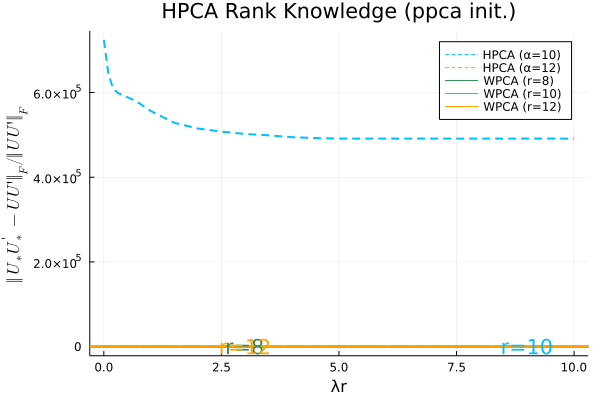

In [372]:
using LaTeXStrings
#plot(λr, error_rpca, label="HPCA (α=0)", title="HPCA Rank Knowledge (zero init.)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2)
#plot(λr, error_hpca_rank8, label="HPCA (α=8)",linewidth=2, c=:seagreen, linestyle=:dash, legend_title_font_pointsize=18)
plot(λr, error_hpca_rank10, label="HPCA (α=10)",linewidth=2,title="HPCA Rank Knowledge (ppca init.)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",c=:deepskyblue, linestyle=:dash)
plot!(λr, error_hpca_rank12, label="HPCA (α=12)",linewidth=2, c=:orange, linestyle=:dash)
hline!([error_wpca_8], label="WPCA (r=8)", linewidth=2, c=:seagreen)
hline!([error_wpca_10], label="WPCA (r=10)", c=:deepskyblue, linewidth=2)
hline!([error_wpca_12], label="WPCA (r=12)", linewidth=2, c=:orange)
annotate!(9, error_wpca_10+0.025, "r=10", :deepskyblue)
annotate!(3, error_wpca_8+0.025, "r=8", :seagreen)
annotate!(3, error_wpca_12+0.025, "r=12", :orange)
#hline!([error_heppcat], label="HePPCAT",linewidth=2)
#savefig("HPCA_KNOWN_RANK_KNOWLEDGE_PPCA_INIT.pdf")

## Not enough good data

In [58]:
using Plots
using Random
using Distributions
using LinearAlgebra
include("pogm_restart.jl") # issues adding MIRT so will use julia file instead
rng = Random.seed!(0)
N = 100
D = 100
d = 10
σ1 = 2
σ2 = 35
goodpts = 5
X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    X[:,k] = U1*U1'*rand(Uniform(-100,100),D)
end
for j=1:N
        if (j<= goodpts)
            Y[:,j] = X[:,j] + rand(Normal(0,σ1),D)
            Π[j] = σ1^2
        else
            Y[:,j] = X[:,j] + rand(Normal(0,σ2),D)
            Π[j] = σ2^2
        end
end
U_WPCA = weightedPCA(Y,Π.^-1,d)
error_wpca = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)
using HePPCAT
heppCAT_matrix = []
push!(heppCAT_matrix, Y[:,1:goodpts])
push!(heppCAT_matrix, Y[:,(goodpts+1):end])
homoPCA = heppcat(heppCAT_matrix,d,0)   # init is homoscedastic PPCA
knownvar = deepcopy(homoPCA)
knownvar.v[1] = σ1^2
knownvar.v[2] = σ2^2
heppCAT_known = heppcat(heppCAT_matrix,d,1000;init=knownvar,vknown=true);
error_heppcat = norm(heppCAT_known.U*heppCAT_known.U' - U1*U1', 2)/norm(U1*U1', 2)
error_homoppca = norm(homoPCA.U*homoPCA.U' - U1*U1', 2)/norm(U1*U1', 2)

0.911788038925258

## HPCA-NNM

In [21]:
λr = vcat(0:0.1:1,1:0.5:10)
λr[1] = 0.001
error_rpca = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_RPCA = HPCA_POGM(Y, λr[i],Π, 0,10,1e-6)  #RPCA_ADMM(Y, λr[i], d, 0.01, 1.005)
    error_rpca[i] = norm(U_RPCA*U_RPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


## HPCA-10

In [23]:
include("pogm_restart.jl")
λr = vcat(0:0.1:1,1:0.5:10)
λr[1] = 0.001
error_hpca = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_POGM(Y, λr[i], Π, 10, d, 1e-6) #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [35]:
colors = theme_palette(:auto).colors

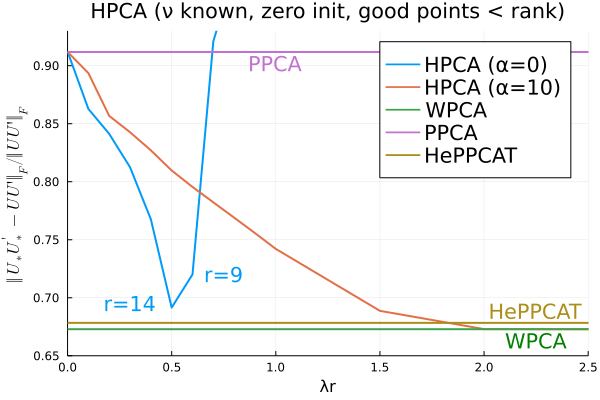

In [64]:
using LaTeXStrings
plot(λr, error_rpca, ylims=(0.65,0.93),xlims=(0,2.5), label="HPCA (α=0)", title="HPCA (ν known, zero init, good points < rank)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2, legendfontsize=14.0)
plot!(λr, error_hpca, label="HPCA (α=10)",linewidth=2)
hline!([error_wpca], label="WPCA", linewidth=2)
hline!([error_homoppca], label="PPCA", linewidth=2)
hline!([error_heppcat], label="HePPCAT",linewidth=2)
annotate!(0.3, 0.695, "r=14", colors[1])
annotate!(0.75, 0.72, "r=9", colors[1])
annotate!(1, error_homoppca-0.01, "PPCA", colors[4])
annotate!(2.25, error_wpca-0.01, "WPCA", :green)
annotate!(2.25, error_heppcat+0.01, "HePPCAT", colors[5])
#savefig("HPCA_KNOWN_BAD_DATA.pdf")